In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [3]:
raw = bucket_raw_path('dend-data',f'capstone/inter-data/crime-data/')
raw

's3://dend-data/capstone/inter-data/crime-data/'

## List objects in bucket

In [4]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/inter-data/crime-data/crime_2009.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2010.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2011.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2012.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2013.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2014.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2015.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2016.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2017.csv',
 's3://dend-data/capstone/inter-data/crime-data/crime_2018.csv']

## Create dataframe from s3 files

In [5]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_csv(i,)
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [6]:
%%time
df = s3_files_to_df(raw)

CPU times: user 3.35 s, sys: 704 ms, total: 4.06 s
Wall time: 1min 19s


In [7]:
df.loc[df.duplicated(keep='first'),:]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year


In [8]:
df.info()
#1,126,465

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122391 entries, 0 to 1122390
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   date_time     1122391 non-null  object
 1   offenses      1122391 non-null  int64 
 2   offense_type  1122391 non-null  object
 3   block_range   1122391 non-null  object
 4   street_name   1122391 non-null  object
 5   type          1122391 non-null  object
 6   suffix        1122391 non-null  object
 7   beat          1122391 non-null  object
 8   premise       1122391 non-null  object
 9   date          1122391 non-null  object
 10  hour          1122391 non-null  int64 
 11  year          1122391 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 102.8+ MB


In [9]:
# convert date_time col to date_time
df.date_time = pd.to_datetime(df.date_time)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122391 entries, 0 to 1122390
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date_time     1122391 non-null  datetime64[ns]
 1   offenses      1122391 non-null  int64         
 2   offense_type  1122391 non-null  object        
 3   block_range   1122391 non-null  object        
 4   street_name   1122391 non-null  object        
 5   type          1122391 non-null  object        
 6   suffix        1122391 non-null  object        
 7   beat          1122391 non-null  object        
 8   premise       1122391 non-null  object        
 9   date          1122391 non-null  object        
 10  hour          1122391 non-null  int64         
 11  year          1122391 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 102.8+ MB


In [11]:
df

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,08/01/09 00:00:00,0,2009
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,08/01/09 00:00:00,0,2009
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,08/01/09 00:00:00,0,2009
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,08/01/09 00:00:00,0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...
1122386,2018-05-27 03:00:00,1,Robbery,4100-4199,DARWIN,-,-,UNK,"Road, Street, or Sidewalk",05/27/2018,3,2018
1122387,2018-05-28 22:00:00,1,Theft,17700-17799,EASTEX,FWY,-,UNK,Apartment Parking Lot,05/28/2018,22,2018
1122388,2018-05-28 22:00:00,1,Theft,900-999,ST EMANUEL,-,-,UNK,Other Parking Lot,05/28/2018,22,2018
1122389,2018-05-30 23:00:00,1,AutoTheft,10800-10899,SHADY,LN,-,UNK,Service or Gas Station,05/30/2018,23,2018


## Show null data

In [12]:
df.apply(lambda x: sum(x.isnull()))

date_time       0
offenses        0
offense_type    0
block_range     0
street_name     0
type            0
suffix          0
beat            0
premise         0
date            0
hour            0
year            0
dtype: int64

In [13]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date_time,0.0
offenses,0.0
offense_type,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
beat,0.0
premise,0.0
date,0.0


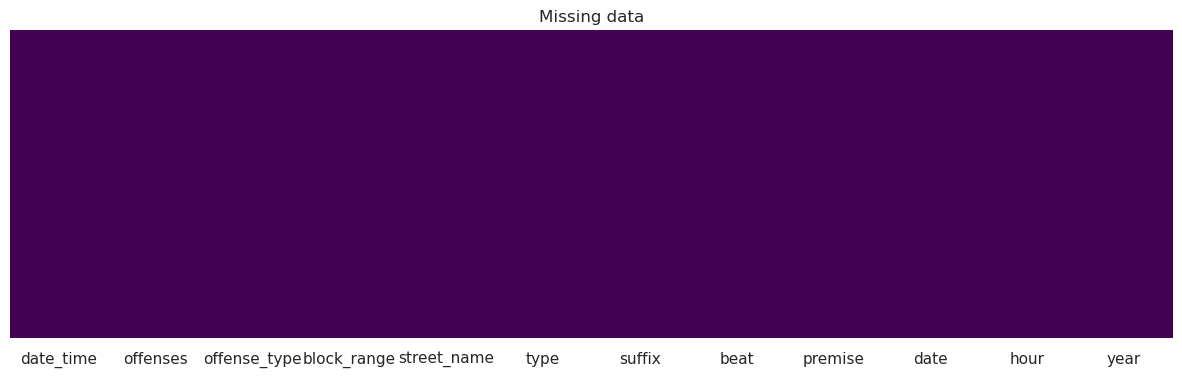

In [14]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122391 entries, 0 to 1122390
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date_time     1122391 non-null  datetime64[ns]
 1   offenses      1122391 non-null  int64         
 2   offense_type  1122391 non-null  object        
 3   block_range   1122391 non-null  object        
 4   street_name   1122391 non-null  object        
 5   type          1122391 non-null  object        
 6   suffix        1122391 non-null  object        
 7   beat          1122391 non-null  object        
 8   premise       1122391 non-null  object        
 9   date          1122391 non-null  object        
 10  hour          1122391 non-null  int64         
 11  year          1122391 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 102.8+ MB


In [16]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,08/01/09 00:00:00,0,2009
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,08/01/09 00:00:00,0,2009
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,08/01/09 00:00:00,0,2009
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,08/01/09 00:00:00,0,2009


## Explore Each Column

In [17]:
def create_new_cell(contents):
    '''created new jupyter cells by inputing a list of columns
    outputs'''
    from IPython.core.getipython import get_ipython
    shell = get_ipython()
    payload = dict(
        source='set_next_input',
        #text=f'#column:{contents}\ndf.{contents}.value_counts(dropna=False)[:10]'.format(contents),
        text=f'# column:{contents}\ndf.{contents}.value_counts(dropna=False)[:10]',
        replace=False,)
    shell.payload_manager.write_payload(payload, single=False)

    
def strip_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df[col] = df[col].str.strip()
    print('after:{}'.format(len(df[col].value_counts(dropna=False))))    
    
def lower_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df[col] = df[col].str.lower()
    print('after:{}'.format(len(df[col].value_counts(dropna=False))))       
    
    
    
def capital_col(col):
    print(f'column:{col}')
    print('before:{}'.format(len(df[col].value_counts(dropna=False))))
    df[col] = df[col].str.capitalize()
    print('after:{}'.format(len(df[col].value_counts(dropna=False))))      

In [18]:
col_list = df.columns.tolist()
col_list

['date_time',
 'offenses',
 'offense_type',
 'block_range',
 'street_name',
 'type',
 'suffix',
 'beat',
 'premise',
 'date',
 'hour',
 'year']

In [19]:
df.date.value_counts(dropna=False)

2010-10-01 00:00:00    487
07/13/09 00:00:00      484
2013-12-20 00:00:00    478
08/01/09 00:00:00      474
2010-07-01 00:00:00    473
                      ... 
1974-04-27 00:00:00      1
2007-02-05 00:00:00      1
2009-09-03 00:00:00      1
2009-03-20 00:00:00      1
02/23/2016               1
Name: date, Length: 4649, dtype: int64

In [20]:
df.date_time.value_counts(dropna=False)

2011-01-01 00:00:00    72
2010-01-01 00:00:00    68
2009-12-01 00:00:00    60
2010-06-01 00:00:00    59
2011-09-01 00:00:00    57
                       ..
2000-12-27 15:00:00     1
2006-01-26 00:00:00     1
2012-12-21 03:00:00     1
2004-12-12 09:00:00     1
2009-01-30 17:00:00     1
Name: date_time, Length: 79685, dtype: int64

In [21]:
df.hour.value_counts(dropna=False)

12    63638
18    63637
17    62322
15    61501
16    59982
19    58776
14    58240
20    57277
13    55306
22    54301
10    53653
11    53092
21    52972
9     50315
8     50119
0     48811
23    44958
7     40825
1     27338
6     26835
2     25457
3     19748
5     17280
4     16004
24        4
Name: hour, dtype: int64

In [ ]:
# # only run once
# for col in col_list:
#     create_new_cell(col)

In [22]:
# column:year
df.year.value_counts(dropna=False)

2010    135357
2013    129699
2012    127109
2011    126855
2016    122682
2014    121410
2015    119941
2017    119724
2009     72600
2018     47014
Name: year, dtype: int64

In [23]:
# column:premise
df.premise.value_counts(dropna=False)[:10]

20A                          83563
20R                          83454
18A                          74091
Residence or House           61222
Apartment Parking Lot        51271
13R                          47017
Road, Street, or Sidewalk    44939
Apartment                    44523
20D                          42251
UNK                          33590
Name: premise, dtype: int64

In [24]:
# get total unique values
len(df.premise.unique())

267

In [25]:
df.premise.unique()

array(['210', '20A', '18N', '18A', '20R', '040', '250', '070', '20D',
       '13R', '140', '11P', '03B', '09D', '18M', '240', '120', '05O',
       '02B', '05Z', '080', '18G', '18H', '01A', '20V', '18O', '18T',
       '05G', '18P', '20G', '18R', '060', '23S', '20L', '20P', '18U',
       '18C', '05R', '05L', '20C', '05T', '11R', '18L', '05W', '24J',
       '18W', '190', '13H', '13B', '14V', '05C', '170', '03S', '05H',
       '13S', '20W', '24E', '100', '22E', '20M', '01P', '22P', '24C',
       '22U', '24F', '05D', '20N', '18B', '09H', '13A', '22D', '11G',
       '05E', '01B', '24T', '05V', '05M', '05X', '05F', '11S', '24P',
       '19V', '05P', '11F', '24B', '09P', '24A', '02C', '24S', '05B',
       '18S', '05S', '22M', '05Q', '05N', '09R', '22H', '02S', '24V',
       '25V', '24G', '150', '160', '13T', '18D', '05A', '11C', '22C',
       '20H', '09V', '11L', '04V', '---', '05Y', '21V', '11V', '12V',
       '01K', '05U', '23C', 'RES', '22V', '25R', '01R', '01T', '24M',
       '13C', '02V',

In [26]:
# get only values that are less than 4 in length
df[df.premise.str.len()<4]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009
1,2009-08-01 00:00:00,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,08/01/09 00:00:00,0,2009
2,2009-08-01 00:00:00,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,08/01/09 00:00:00,0,2009
3,2009-08-01 00:00:00,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,08/01/09 00:00:00,0,2009
4,2009-08-01 00:00:00,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,08/01/09 00:00:00,0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...
1036515,2017-03-07 21:00:00,1,Robbery,6400-6499,MARKET,ST,-,9C20,UNK,2017-03-07 00:00:00,21,2017
1036544,2017-03-15 00:00:00,1,Theft,10300-10399,EAST,FWY,-,9C30,UNK,2017-03-15 00:00:00,0,2017
1036583,2017-03-23 10:00:00,1,Burglary,400-499,MERCURY,DR,-,9C30,UNK,2017-03-23 00:00:00,10,2017
1036648,2017-03-08 20:00:00,1,Theft,12000-12099,EAST,FWY,-,9C40,UNK,2017-03-08 00:00:00,20,2017


In [27]:
# only the premise column
df[df.premise.str.len()<4].premise

0          210
1          20A
2          18N
3          18A
4          18N
          ... 
1036515    UNK
1036544    UNK
1036583    UNK
1036648    UNK
1036782    UNK
Name: premise, Length: 677091, dtype: object

In [28]:
# unique values
df[df.premise.str.len()<4].premise.unique()

array(['210', '20A', '18N', '18A', '20R', '040', '250', '070', '20D',
       '13R', '140', '11P', '03B', '09D', '18M', '240', '120', '05O',
       '02B', '05Z', '080', '18G', '18H', '01A', '20V', '18O', '18T',
       '05G', '18P', '20G', '18R', '060', '23S', '20L', '20P', '18U',
       '18C', '05R', '05L', '20C', '05T', '11R', '18L', '05W', '24J',
       '18W', '190', '13H', '13B', '14V', '05C', '170', '03S', '05H',
       '13S', '20W', '24E', '100', '22E', '20M', '01P', '22P', '24C',
       '22U', '24F', '05D', '20N', '18B', '09H', '13A', '22D', '11G',
       '05E', '01B', '24T', '05V', '05M', '05X', '05F', '11S', '24P',
       '19V', '05P', '11F', '24B', '09P', '24A', '02C', '24S', '05B',
       '18S', '05S', '22M', '05Q', '05N', '09R', '22H', '02S', '24V',
       '25V', '24G', '150', '160', '13T', '18D', '05A', '11C', '22C',
       '20H', '09V', '11L', '04V', '---', '05Y', '21V', '11V', '12V',
       '01K', '05U', '23C', 'RES', '22V', '25R', '01R', '01T', '24M',
       '13C', '02V',

In [29]:
limited = df[df.premise.str.len()<4]
limited.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,08/01/09 00:00:00,0,2009
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,08/01/09 00:00:00,0,2009
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,08/01/09 00:00:00,0,2009
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,08/01/09 00:00:00,0,2009


In [30]:
limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677091 entries, 0 to 1036782
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     677091 non-null  datetime64[ns]
 1   offenses      677091 non-null  int64         
 2   offense_type  677091 non-null  object        
 3   block_range   677091 non-null  object        
 4   street_name   677091 non-null  object        
 5   type          677091 non-null  object        
 6   suffix        677091 non-null  object        
 7   beat          677091 non-null  object        
 8   premise       677091 non-null  object        
 9   date          677091 non-null  object        
 10  hour          677091 non-null  int64         
 11  year          677091 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 67.2+ MB


# load premise dataset

In [31]:
ls ../../data/raw/crime_data/

1985_2014/  2010/  2016/  clean/
2005/       2011/  2017/  NIBRS_Public_Data_Dictionary_050919.pdf*
2006/       2012/  2018/  premise_codes.csv*
2007/       2013/  2019/  txucrofnscodetbl.xlsx*
2008/       2014/  2020/
2009/       2015/  2021/


In [32]:
file = 'premise_codes.csv'
raw_directory = os.path.join('..','..','data','raw','crime_data',f'{file}')
raw_directory

'../../data/raw/crime_data/premise_codes.csv'

In [33]:
premise_df = pd.read_csv(raw_directory)
premise_df.columns = premise_df.columns.str.strip().str.lower().str.replace('-', '_').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
# rename premise column for easy merge
premise_df.rename(columns={'premise_type': 'premise',}, inplace=True)
premise_df.head()

<ipython-input-33-063be65e9463>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,premise,premise_description
0,01A,AIRPORT TERMINAL
1,01B,BUS STATION
2,01K,RAILROAD TRACK/RIGHT OF WAY
3,01P,PARK & RIDE TERMINAL
4,01R,LIGHT RAIL VEHICLE


In [34]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(premise_df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
premise,0.0
premise_description,0.0


In [35]:
premise_df.head()

,premise,premise_description
0,01A,AIRPORT TERMINAL
1,01B,BUS STATION
2,01K,RAILROAD TRACK/RIGHT OF WAY
3,01P,PARK & RIDE TERMINAL
4,01R,LIGHT RAIL VEHICLE


In [36]:
# merge with premise df
df = pd.merge(df,premise_df, on='premise', how='outer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122392 entries, 0 to 1122391
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1122391 non-null  datetime64[ns]
 1   offenses             1122391 non-null  float64       
 2   offense_type         1122391 non-null  object        
 3   block_range          1122391 non-null  object        
 4   street_name          1122391 non-null  object        
 5   type                 1122391 non-null  object        
 6   suffix               1122391 non-null  object        
 7   beat                 1122391 non-null  object        
 8   premise              1122392 non-null  object        
 9   date                 1122391 non-null  object        
 10  hour                 1122391 non-null  float64       
 11  year                 1122391 non-null  float64       
 12  premise_description  641098 non-null   object        
dt

In [37]:
df.premise_description.value_counts(dropna=False)

NaN                                  481294
APARTMENT                             83563
RESIDENCE/HOUSE                       83454
APARTMENT PARKING LOT                 74091
ROAD/STREET/SIDEWALK                  47017
                                      ...  
MARINE VEH. SALES,BOATS,SAILBOATS        11
LIGHT RAIL VEHICLE                        7
CONTRA-FLOW/HOV                           5
VACANT BANK                               1
VACANT JAIL/PRISON                        1
Name: premise_description, Length: 127, dtype: int64

In [38]:
df[['premise','premise_description']]

,premise,premise_description
0,210,RESTAURANT/CAFETERIA
1,210,RESTAURANT/CAFETERIA
2,210,RESTAURANT/CAFETERIA
3,210,RESTAURANT/CAFETERIA
4,210,RESTAURANT/CAFETERIA
...,...,...
1122387,Not Listed,NaN
1122388,Not Listed,NaN
1122389,Escort Business,NaN
1122390,Escort Business,NaN


In [39]:
# merge ,
# if value is null in premise_descriptiom, copy the matching row of premise to it
df.loc[df['premise_description'].isnull(),'premise_description'] = df['premise']

In [40]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1.0,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0.0,2009.0,RESTAURANT/CAFETERIA
1,2009-08-01 01:00:00,1.0,Theft,6000-6099,RICHMOND,AVE,-,18F30,210,08/01/09 00:00:00,1.0,2009.0,RESTAURANT/CAFETERIA
2,2009-08-01 04:00:00,1.0,Burglary,3900-3999,BROADWAY,ST,-,13D20,210,08/01/09 00:00:00,4.0,2009.0,RESTAURANT/CAFETERIA
3,2009-08-01 05:00:00,1.0,Burglary,8500-8599,BELLAIRE,BLVD,-,18F60,210,08/01/09 00:00:00,5.0,2009.0,RESTAURANT/CAFETERIA
4,2009-08-01 19:00:00,1.0,Theft,1100-1199,UPTOWN PARK,BLVD,-,18F20,210,08/01/09 00:00:00,19.0,2009.0,RESTAURANT/CAFETERIA


In [41]:
df[['premise','premise_description']]

,premise,premise_description
0,210,RESTAURANT/CAFETERIA
1,210,RESTAURANT/CAFETERIA
2,210,RESTAURANT/CAFETERIA
3,210,RESTAURANT/CAFETERIA
4,210,RESTAURANT/CAFETERIA
...,...,...
1122387,Not Listed,Not Listed
1122388,Not Listed,Not Listed
1122389,Escort Business,Escort Business
1122390,Escort Business,Escort Business


In [42]:
len(df.premise_description.unique())

268

In [43]:
df.premise_description.value_counts()

APARTMENT                             83563
RESIDENCE/HOUSE                       83454
APARTMENT PARKING LOT                 74091
Residence or House                    61222
Apartment Parking Lot                 51271
                                      ...  
Escort Business                           2
Contra-Flow, Managed, or HOV Lanes        1
Vacant Jail or Prison                     1
VACANT BANK                               1
VACANT JAIL/PRISON                        1
Name: premise_description, Length: 268, dtype: int64

In [44]:
strip_col('premise_description')

column:premise_description
before:268
after:267


In [45]:
lower_col('premise_description')

column:premise_description
before:267
after:209


In [46]:
df.premise_description = df.premise_description.str.replace('/', ' ').str.replace(',', ' ').str.replace('(', '').str.replace(')', '').str.strip()

<ipython-input-46-8c6d8ff865eb>:1: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [47]:
len(df.premise_description.value_counts())

208

In [48]:
df[df.year.isna()]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
1122391,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15V,NaN,NaN,NaN,vacant jail prison


In [49]:
df = df[~df.year.isna()]

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122391 entries, 0 to 1122390
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1122391 non-null  datetime64[ns]
 1   offenses             1122391 non-null  float64       
 2   offense_type         1122391 non-null  object        
 3   block_range          1122391 non-null  object        
 4   street_name          1122391 non-null  object        
 5   type                 1122391 non-null  object        
 6   suffix               1122391 non-null  object        
 7   beat                 1122391 non-null  object        
 8   premise              1122391 non-null  object        
 9   date                 1122391 non-null  object        
 10  hour                 1122391 non-null  float64       
 11  year                 1122391 non-null  float64       
 12  premise_description  1122391 non-null  object        
dt

In [51]:
df.premise_description.value_counts()

apartment                             128086
apartment parking lot                 125362
residence house                        83454
residence or house                     61222
driveway                               59753
                                       ...  
modeling studio                            4
res                                        2
escort business                            2
vacant jail or prison                      1
contra-flow  managed  or hov lanes         1
Name: premise_description, Length: 207, dtype: int64

In [52]:
df[df.premise_description.str.len()<=4].premise_description.value_counts()

unk     33590
---      2239
bank     1745
n          86
06         71
23c         6
res         2
Name: premise_description, dtype: int64

# find most common workd

In [53]:
from collections import Counter
Counter(" ".join(df.premise_description).split()).most_common(50)

[('parking', 325730),
 ('lot', 325730),
 ('apartment', 257290),
 ('or', 219549),
 ('house', 147165),
 ('residence', 147074),
 ('store', 112203),
 ('road', 92958),
 ('street', 91956),
 ('sidewalk', 91956),
 ('other', 77988),
 ('driveway', 59753),
 ('restaurant', 53022),
 ('cafeteria', 52852),
 ('department', 42895),
 ('discount', 42895),
 ('business', 38552),
 ('commercial', 37186),
 ('grocery', 37040),
 ('supermarket', 37040),
 ('garage', 35238),
 ('unk', 33590),
 ('unknown', 26945),
 ('club', 25873),
 ('non-specific', 25856),
 ('hotel', 24913),
 ('motel', 24913),
 ('convenience', 24780),
 ('bar', 21301),
 ('night', 21301),
 ('center', 21166),
 ('station', 20631),
 ('strip', 20498),
 ('service', 19950),
 ('gas', 19266),
 ('building', 17376),
 ('etc.', 13523),
 ('auto', 13083),
 ('miscellaneous', 11837),
 ('mall', 11516),
 ('pool', 11127),
 ('office', 9959),
 ('specialty', 8554),
 ('not', 8268),
 ('listed', 8226),
 ('vacant', 7737),
 ('carport', 7550),
 ('rental', 7013),
 ('church', 693

In [54]:
len(df.premise_description.value_counts(dropna=False))

207

In [55]:
df[df.date_time.isna()]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description


In [56]:
# only non null values
df = df[~df.date_time.isna()]

In [58]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1.0,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0.0,2009.0,restaurant cafeteria
1,2009-08-01 01:00:00,1.0,Theft,6000-6099,RICHMOND,AVE,-,18F30,210,08/01/09 00:00:00,1.0,2009.0,restaurant cafeteria
2,2009-08-01 04:00:00,1.0,Burglary,3900-3999,BROADWAY,ST,-,13D20,210,08/01/09 00:00:00,4.0,2009.0,restaurant cafeteria
3,2009-08-01 05:00:00,1.0,Burglary,8500-8599,BELLAIRE,BLVD,-,18F60,210,08/01/09 00:00:00,5.0,2009.0,restaurant cafeteria
4,2009-08-01 19:00:00,1.0,Theft,1100-1199,UPTOWN PARK,BLVD,-,18F20,210,08/01/09 00:00:00,19.0,2009.0,restaurant cafeteria


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122391 entries, 0 to 1122390
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1122391 non-null  datetime64[ns]
 1   offenses             1122391 non-null  float64       
 2   offense_type         1122391 non-null  object        
 3   block_range          1122391 non-null  object        
 4   street_name          1122391 non-null  object        
 5   type                 1122391 non-null  object        
 6   suffix               1122391 non-null  object        
 7   beat                 1122391 non-null  object        
 8   premise              1122391 non-null  object        
 9   date                 1122391 non-null  object        
 10  hour                 1122391 non-null  float64       
 11  year                 1122391 non-null  float64       
 12  premise_description  1122391 non-null  object        
dt

In [59]:
df['offenses'] = df['offenses'].astype('int64')
df['year'] = df['year'].astype('int64')
df['hour'] = df['hour'].astype('int64')

In [60]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009,restaurant cafeteria
1,2009-08-01 01:00:00,1,Theft,6000-6099,RICHMOND,AVE,-,18F30,210,08/01/09 00:00:00,1,2009,restaurant cafeteria
2,2009-08-01 04:00:00,1,Burglary,3900-3999,BROADWAY,ST,-,13D20,210,08/01/09 00:00:00,4,2009,restaurant cafeteria
3,2009-08-01 05:00:00,1,Burglary,8500-8599,BELLAIRE,BLVD,-,18F60,210,08/01/09 00:00:00,5,2009,restaurant cafeteria
4,2009-08-01 19:00:00,1,Theft,1100-1199,UPTOWN PARK,BLVD,-,18F20,210,08/01/09 00:00:00,19,2009,restaurant cafeteria


In [61]:
df.apply(lambda x: sum(x.isnull()))

date_time              0
offenses               0
offense_type           0
block_range            0
street_name            0
type                   0
suffix                 0
beat                   0
premise                0
date                   0
hour                   0
year                   0
premise_description    0
dtype: int64

In [62]:
# column:beat
df.beat.value_counts(dropna=False)

19G10     23848
12D10     23696
1A20      23393
6B60      21695
13D20     21223
          ...  
'24C20        1
x             1
'23J50        1
7C60          1
3B20          1
Name: beat, Length: 243, dtype: int64

In [63]:
df.beat.unique()

array(['3B30', '18F30', '13D20', '18F60', '18F20', '12D10', '17E10',
       '12D30', '20G60', '6B50', '1A40', '3B50', '15E10', '6B40', '1A30',
       '7C20', '10H80', '13D10', '19G50', '18F40', '11H10', '6B10',
       '3B10', '4F10', '1A20', '20G50', '14D10', '1A50', '2A30', '14D30',
       '9C40', '10H70', '1A10', '11H30', '10H50', '12D60', '2A60', '8C60',
       '7C30', '17E20', '3B40', '5F40', '20G30', '5F30', '12D50', '5F10',
       '17E40', '24C20', '10H30', '10H10', '6B60', '19G20', '8C20',
       '19G40', '2A40', '8C10', '10H40', '15E30', '15E40', '19G10',
       '4F30', '8C50', '2A10', '14D20', '6B30', '19G30', '2A50', '16E20',
       '9C30', '20G40', '20G20', '20G10', '17E30', '12D40', '9C20',
       '18F50', '2A20', 'UNK', '20G80', '10H60', '12D20', '24C40', '5F20',
       '11H20', '13D40', '16E40', '4F20', '15E20', '24C10', '6B20',
       '16E30', '20G70', '13D30', '11H50', '7C50', '9C10', '8C40',
       '10H20', '18F10', '14D50', '21I30', '12D70', '16E10', '7C10',
       '2

In [64]:
# replace extra ' with empty space
df['beat'] = df.beat.str.replace("'", " ")

In [65]:
strip_col('beat')

column:beat
before:243
after:132


In [66]:
df.beat.unique()

array(['3B30', '18F30', '13D20', '18F60', '18F20', '12D10', '17E10',
       '12D30', '20G60', '6B50', '1A40', '3B50', '15E10', '6B40', '1A30',
       '7C20', '10H80', '13D10', '19G50', '18F40', '11H10', '6B10',
       '3B10', '4F10', '1A20', '20G50', '14D10', '1A50', '2A30', '14D30',
       '9C40', '10H70', '1A10', '11H30', '10H50', '12D60', '2A60', '8C60',
       '7C30', '17E20', '3B40', '5F40', '20G30', '5F30', '12D50', '5F10',
       '17E40', '24C20', '10H30', '10H10', '6B60', '19G20', '8C20',
       '19G40', '2A40', '8C10', '10H40', '15E30', '15E40', '19G10',
       '4F30', '8C50', '2A10', '14D20', '6B30', '19G30', '2A50', '16E20',
       '9C30', '20G40', '20G20', '20G10', '17E30', '12D40', '9C20',
       '18F50', '2A20', 'UNK', '20G80', '10H60', '12D20', '24C40', '5F20',
       '11H20', '13D40', '16E40', '4F20', '15E20', '24C10', '6B20',
       '16E30', '20G70', '13D30', '11H50', '7C50', '9C10', '8C40',
       '10H20', '18F10', '14D50', '21I30', '12D70', '16E10', '7C10',
       '2

In [67]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009,restaurant cafeteria
1,2009-08-01 01:00:00,1,Theft,6000-6099,RICHMOND,AVE,-,18F30,210,08/01/09 00:00:00,1,2009,restaurant cafeteria
2,2009-08-01 04:00:00,1,Burglary,3900-3999,BROADWAY,ST,-,13D20,210,08/01/09 00:00:00,4,2009,restaurant cafeteria
3,2009-08-01 05:00:00,1,Burglary,8500-8599,BELLAIRE,BLVD,-,18F60,210,08/01/09 00:00:00,5,2009,restaurant cafeteria
4,2009-08-01 19:00:00,1,Theft,1100-1199,UPTOWN PARK,BLVD,-,18F20,210,08/01/09 00:00:00,19,2009,restaurant cafeteria


In [68]:
# column:suffix
df.suffix.value_counts(dropna=False)

-    970374
W     63674
S     47836
N     24405
E     16102
Name: suffix, dtype: int64

In [69]:
# column:type
df.type.value_counts(dropna=False)

-          271240
DR         231593
ST         196531
RD         172221
BLVD        63811
FWY         61048
LN          43646
PKWY        26607
AVE         21107
FWY SER      8642
CT           6861
WAY          6852
TRL          3972
CIR          3041
SER          1817
HWY          1726
PL           1205
LP            139
BYP            93
RAMP           63
PASS           47
COVE           29
VIEW           28
PRK            26
WALK           11
BND             7
SQ              6
MNR             4
PT              4
PATH            3
UTRN            3
TER             3
RDG             2
GRN             1
SPUR            1
XING            1
Name: type, dtype: int64

In [70]:
strip_col('type')

column:type
before:36
after:36


In [71]:
lower_col('type')

column:type
before:36
after:36


# Street Name
- lowercase all to merge

In [72]:
# column:street_name
df.street_name.value_counts(dropna=False)[:10]

WESTHEIMER    29980
GULF          15532
GESSNER       15440
NORTH         13921
RICHMOND      13602
KATY          11056
SOUTHWEST     10891
MAIN          10198
BISSONNET     10130
NORTHWEST      9811
Name: street_name, dtype: int64

In [73]:
df[df.street_name.str.contains('NAN')].street_name.unique().tolist()

['NANCE',
 'NANTUCKET',
 'FERDINAND',
 'DRENNAN',
 'RONAN PARK PLACE',
 'SAN FERNANDO',
 'BONANZA',
 'NENANA',
 'SHENANDOAH',
 'BUCHANAN',
 'NAN',
 'HEFFERNAN',
 'COVENANT SPRINGS',
 'NANTUCKET WOODS',
 'RONAN PARK',
 'NANCY ANN',
 'HEFFERNAN ST',
 'NENANA DRIVE',
 'NENANA DR',
 'DRENNAN ST',
 'NANTUCKET DR',
 'NAN ST',
 'COVENANT CREST',
 'RONAN',
 'RONAN PARK PL',
 'NANCY BELL',
 'DRENNAN ST. APT. 1',
 'BONANZA RD',
 'N DRENNAN ST',
 'N. DRENNAN',
 'BUCHANAN HILL',
 'B NANTUCKET']

In [74]:
test = df.copy()

In [75]:
df.street_name = df.street_name.replace('NAN',np.nan)

In [76]:
df[df.street_name.str.contains('NAN')].street_name.unique().tolist()

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122391 entries, 0 to 1122390
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1122391 non-null  datetime64[ns]
 1   offenses             1122391 non-null  int64         
 2   offense_type         1122391 non-null  object        
 3   block_range          1122391 non-null  object        
 4   street_name          1122384 non-null  object        
 5   type                 1122391 non-null  object        
 6   suffix               1122391 non-null  object        
 7   beat                 1122391 non-null  object        
 8   premise              1122391 non-null  object        
 9   date                 1122391 non-null  object        
 10  hour                 1122391 non-null  int64         
 11  year                 1122391 non-null  int64         
 12  premise_description  1122391 non-null  object        
dt

In [79]:
df[df.street_name.isna()]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
201649,2011-04-30 06:00:00,1,Aggravated Assault,3900-3999,NaN,-,-,3B10,20R,2011-04-30 00:00:00,6,2011,residence house
237489,2013-08-04 01:00:00,1,Aggravated Assault,3900-3999,NaN,-,-,3B10,20R,2013-08-04 00:00:00,1,2013,residence house
322803,2013-03-01 23:00:00,1,Auto Theft,3800-3899,NaN,-,-,3B10,20D,2013-03-01 00:00:00,23,2013,driveway
889229,2016-09-15 16:00:00,1,Robbery,3900-3999,NaN,-,-,3B10,Apartment,2016-09-15 00:00:00,16,2016,apartment
900379,2017-09-15 16:00:00,1,Burglary,3900-3999,NaN,st,-,20G40,Apartment,09/15/2017,16,2017,apartment
905279,2018-05-19 17:00:00,1,Theft,3900-3999,NaN,st,-,3B10,Apartment,05/19/2018,17,2018,apartment
951578,2018-01-08 09:00:00,1,AutoTheft,3900-3999,NaN,st,-,2A10,"Road, Street, or Sidewalk",01/08/2018,9,2018,road street or sidewalk


In [80]:
# CHANGE Nan with unk

In [81]:
df.street_name.fillna('UNK',inplace=True)

In [82]:
df[df.street_name.isna()]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description


In [83]:
strip_col('street_name')

column:street_name
before:28322
after:28319


In [84]:
lower_col('street_name')

column:street_name
before:28319
after:28319


In [85]:
# column:block_range
df.block_range.value_counts(dropna=False)[:30]

900-999      15552
100-199      15436
800-899      13306
700-799      12933
2400-2499    12751
2300-2399    12605
1000-1099    12591
7900-7999    12428
9400-9499    12390
300-399      12210
4400-4499    12195
200-299      12178
500-599      11861
1500-1599    11618
9500-9599    11616
1300-1399    11364
2500-2599    11309
7500-7599    11183
2700-2799    11141
1100-1199    11085
1200-1299    10822
1400-1499    10783
600-699      10738
5000-5099    10537
5800-5899    10384
2100-2199    10121
2000-2099    10098
5900-5999    10077
400-499      10030
6000-6099     9949
Name: block_range, dtype: int64

In [86]:
strip_col('block_range')

column:block_range
before:363
after:363


In [87]:
# column:offense_type
df.offense_type.value_counts(dropna=False)[:10]

Theft                 616262
Burglary              203592
Auto Theft             99928
Aggravated Assault     93863
Robbery                86343
AutoTheft              12193
Rape                    8035
Murder                  2161
1                         14
Name: offense_type, dtype: int64

In [88]:
# combine Auto Theft & AutoTheft
# join Auto Theft & AutoTheft
df.offense_type = df.offense_type.replace('AutoTheft','Auto Theft')

In [89]:
# column:offense_type
df.offense_type.value_counts(dropna=False)[:10]

Theft                 616262
Burglary              203592
Auto Theft            112121
Aggravated Assault     93863
Robbery                86343
Rape                    8035
Murder                  2161
1                         14
Name: offense_type, dtype: int64

## Find out where the '1' comes from

In [90]:
df[df.offense_type.str.contains('1')]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
657191,2015-07-30 16:00:00,1,1,8400-8499,tavenor,ln,-,13D40,Residence or House,2015-07-30 00:00:00,16,2015,residence or house
673803,2016-07-15 00:00:00,1,1,11200-11299,sageland,dr,-,12D20,Residence or House,2016-07-15 00:00:00,0,2016,residence or house
674680,2016-07-02 14:00:00,1,1,11600-11699,gessner,rd,N,5F40,Residence or House,2016-07-02 00:00:00,14,2016,residence or house
688414,2016-12-31 01:00:00,1,1,4200-4299,oak shadows,dr,-,6B20,Residence or House,2016-12-31 00:00:00,1,2017,residence or house
803740,2015-01-01 00:00:00,1,1,800-899,eastlake,st,-,12D10,UNK,2015-01-01 00:00:00,0,2015,unk
804876,2013-08-31 00:00:00,1,1,9200-9299,nyssa,-,-,8C50,UNK,2013-08-31 00:00:00,0,2015,unk
868207,2015-12-04 13:00:00,1,1,7800-7899,airport,blvd,W,17E40,Apartment,2015-12-04 00:00:00,13,2015,apartment
873355,2015-03-19 21:00:00,1,1,9300-9399,long point,rd,-,4F10,Apartment,2015-03-19 00:00:00,21,2015,apartment
876604,2013-09-27 06:00:00,1,1,1500-1599,bailey st 424,-,-,UNK,Apartment,2013-09-27 00:00:00,6,2015,apartment
881410,2015-11-17 00:00:00,1,1,8600-8699,sterlingshire,-,-,8C50,Apartment,2015-11-17 00:00:00,0,2016,apartment


# remove it

In [91]:
# show the oposite of result of '1'. ie only show values that are NOT '1'
# 1,126,346
df = df[~df.offense_type.str.contains('1')]

In [92]:
df[df.offense_type.str.contains('1')]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description


In [93]:
# column:offense_type
df.offense_type.value_counts(dropna=False)[:10]

Theft                 616262
Burglary              203592
Auto Theft            112121
Aggravated Assault     93863
Robbery                86343
Rape                    8035
Murder                  2161
Name: offense_type, dtype: int64

In [94]:
# column:offenses
df.offenses.value_counts(dropna=False)[:20]

1     1108142
2       11932
3        1822
4         287
5          91
6          52
7          16
8          11
9           6
13          4
16          3
10          3
11          2
12          2
17          2
29          1
33          1
Name: offenses, dtype: int64

In [95]:
# column:date_time
df.date_time.value_counts(dropna=False)[:10]

2011-01-01    72
2010-01-01    68
2009-12-01    60
2010-06-01    59
2011-09-01    57
2010-04-01    53
2011-08-01    53
2009-08-01    53
2009-11-01    52
2011-10-01    49
Name: date_time, dtype: int64

In [96]:
df = df.reset_index(drop=True)

In [97]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1,Robbery,3000-3099,durham,dr,N,3B30,210,08/01/09 00:00:00,0,2009,restaurant cafeteria
1,2009-08-01 01:00:00,1,Theft,6000-6099,richmond,ave,-,18F30,210,08/01/09 00:00:00,1,2009,restaurant cafeteria
2,2009-08-01 04:00:00,1,Burglary,3900-3999,broadway,st,-,13D20,210,08/01/09 00:00:00,4,2009,restaurant cafeteria
3,2009-08-01 05:00:00,1,Burglary,8500-8599,bellaire,blvd,-,18F60,210,08/01/09 00:00:00,5,2009,restaurant cafeteria
4,2009-08-01 19:00:00,1,Theft,1100-1199,uptown park,blvd,-,18F20,210,08/01/09 00:00:00,19,2009,restaurant cafeteria


In [99]:
df.info()
# 1,122,377

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122377 entries, 0 to 1122376
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1122377 non-null  datetime64[ns]
 1   offenses             1122377 non-null  int64         
 2   offense_type         1122377 non-null  object        
 3   block_range          1122377 non-null  object        
 4   street_name          1122377 non-null  object        
 5   type                 1122377 non-null  object        
 6   suffix               1122377 non-null  object        
 7   beat                 1122377 non-null  object        
 8   premise              1122377 non-null  object        
 9   date                 1122377 non-null  object        
 10  hour                 1122377 non-null  int64         
 11  year                 1122377 non-null  int64         
 12  premise_description  1122377 non-null  object        
dt

In [100]:
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1,Robbery,3000-3099,durham,dr,N,3B30,210,08/01/09 00:00:00,0,2009,restaurant cafeteria
1,2009-08-01 01:00:00,1,Theft,6000-6099,richmond,ave,-,18F30,210,08/01/09 00:00:00,1,2009,restaurant cafeteria
2,2009-08-01 04:00:00,1,Burglary,3900-3999,broadway,st,-,13D20,210,08/01/09 00:00:00,4,2009,restaurant cafeteria
3,2009-08-01 05:00:00,1,Burglary,8500-8599,bellaire,blvd,-,18F60,210,08/01/09 00:00:00,5,2009,restaurant cafeteria
4,2009-08-01 19:00:00,1,Theft,1100-1199,uptown park,blvd,-,18F20,210,08/01/09 00:00:00,19,2009,restaurant cafeteria


In [101]:
df.hour.value_counts()

12    63638
18    63636
17    62322
15    61501
16    59981
19    58776
14    58239
20    57275
13    55305
22    54301
10    53653
11    53092
21    52971
9     50315
8     50119
0     48807
23    44957
7     40825
1     27337
6     26834
2     25457
3     19748
5     17280
4     16004
24        4
Name: hour, dtype: int64

In [102]:
t = df[df.hour ==24]
d = df[df.hour ==0]


In [103]:
df.date_time.min()

Timestamp('1914-09-08 07:00:00')

In [104]:
d.date_time.dt.hour

0          0
77         0
78         0
86         0
99         0
          ..
1122299    0
1122305    0
1122352    0
1122364    0
1122376    0
Name: date_time, Length: 48807, dtype: int64

In [105]:
t.date_time.dt.hour

781230     0
897980     0
941535     0
1117674    0
Name: date_time, dtype: int64

In [106]:
t.date_time.dt.day

781230      9
897980      8
941535     30
1117674    11
Name: date_time, dtype: int64

In [107]:
t

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
781230,2014-07-09,1,Theft,6200-6299,gulfton,-,-,17E10,UNK,2014-07-08 00:00:00,24,2014,unk
897980,2017-11-08,1,Theft,2200-2299,maroneal,-,-,10H80,Apartment,11/07/2017,24,2017,apartment
941535,2017-01-30,1,Theft,1100-1199,oliver,st,-,2A40,"Road, Street, or Sidewalk",2017-01-29 00:00:00,24,2017,road street or sidewalk
1117674,2017-01-11,1,Theft,7800-7899,airport,blvd,-,23J50,Airport Terminal,2017-01-10 00:00:00,24,2017,airport terminal


# Select ony dates from `2009` to `2018`


In [ ]:
df.date_time.min()

In [ ]:
df.date_time.max()

In [108]:
#greater than the start date and smaller than the end date
start_date = '2009-01-01' #Jan 01 2009
end_date = '2018-12-31' # may 31 2018
mask = (df['date_time'] > start_date) & (df['date_time'] <= end_date)

In [110]:
df2 = df.loc[mask].reset_index(drop=True)
df2.info()
#  1,121,231

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121231 entries, 0 to 1121230
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1121231 non-null  datetime64[ns]
 1   offenses             1121231 non-null  int64         
 2   offense_type         1121231 non-null  object        
 3   block_range          1121231 non-null  object        
 4   street_name          1121231 non-null  object        
 5   type                 1121231 non-null  object        
 6   suffix               1121231 non-null  object        
 7   beat                 1121231 non-null  object        
 8   premise              1121231 non-null  object        
 9   date                 1121231 non-null  object        
 10  hour                 1121231 non-null  int64         
 11  year                 1121231 non-null  int64         
 12  premise_description  1121231 non-null  object        
dt

In [111]:
df2.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
0,2009-08-01 00:00:00,1,Robbery,3000-3099,durham,dr,N,3B30,210,08/01/09 00:00:00,0,2009,restaurant cafeteria
1,2009-08-01 01:00:00,1,Theft,6000-6099,richmond,ave,-,18F30,210,08/01/09 00:00:00,1,2009,restaurant cafeteria
2,2009-08-01 04:00:00,1,Burglary,3900-3999,broadway,st,-,13D20,210,08/01/09 00:00:00,4,2009,restaurant cafeteria
3,2009-08-01 05:00:00,1,Burglary,8500-8599,bellaire,blvd,-,18F60,210,08/01/09 00:00:00,5,2009,restaurant cafeteria
4,2009-08-01 19:00:00,1,Theft,1100-1199,uptown park,blvd,-,18F20,210,08/01/09 00:00:00,19,2009,restaurant cafeteria


In [112]:
df2.date_time.min()

Timestamp('2009-01-01 02:00:00')

In [113]:
df2.date_time.max()

Timestamp('2018-05-31 23:00:00')

# check for nulls befor saving

In [114]:
df2.apply(lambda x: sum(x.isnull()))

date_time              0
offenses               0
offense_type           0
block_range            0
street_name            0
type                   0
suffix                 0
beat                   0
premise                0
date                   0
hour                   0
year                   0
premise_description    0
dtype: int64

In [115]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121231 entries, 0 to 1121230
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_time            1121231 non-null  datetime64[ns]
 1   offenses             1121231 non-null  int64         
 2   offense_type         1121231 non-null  object        
 3   block_range          1121231 non-null  object        
 4   street_name          1121231 non-null  object        
 5   type                 1121231 non-null  object        
 6   suffix               1121231 non-null  object        
 7   beat                 1121231 non-null  object        
 8   premise              1121231 non-null  object        
 9   date                 1121231 non-null  object        
 10  hour                 1121231 non-null  int64         
 11  year                 1121231 non-null  int64         
 12  premise_description  1121231 non-null  object        
dt

In [118]:
df2.iloc[202620]

date_time              2011-08-05 12:00:00
offenses                                 1
offense_type            Aggravated Assault
block_range                    10700-10799
street_name                        donegal
type                                   way
suffix                                   -
beat                                 14D40
premise                                20R
date                   2011-08-05 00:00:00
hour                                    12
year                                  2011
premise_description        residence house
Name: 202620, dtype: object

In [120]:
df2.loc[df2['date_time'] == '2011-04-30 06:00:00']


,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
38110,2011-04-30 06:00:00,1,Burglary,3900-3999,mandell,-,-,1A30,20A,2011-04-30 00:00:00,6,2011,apartment
50147,2011-04-30 06:00:00,1,Theft,7400-7499,calhoun,rd,-,14D20,20A,2011-04-30 00:00:00,6,2011,apartment
201338,2011-04-30 06:00:00,1,Aggravated Assault,3900-3999,unk,-,-,3B10,20R,2011-04-30 00:00:00,6,2011,residence house
212431,2011-04-30 06:00:00,1,Burglary,3500-3599,canfield,st,-,10H50,20R,2011-04-30 00:00:00,6,2011,residence house
283485,2011-04-30 06:00:00,1,Theft,2300-2399,west sam houston,pkwy,N,4F20,070,2011-04-30 00:00:00,6,2011,convenience store
344359,2011-04-30 06:00:00,1,Robbery,9500-9599,deering,dr,-,19G10,13R,2011-04-30 00:00:00,6,2011,road street sidewalk
409112,2011-04-30 06:00:00,1,Theft,1500-1599,wirt,rd,-,5F10,120,2011-04-30 00:00:00,6,2011,grocery supermarket


In [121]:
df2.loc[df2.duplicated(keep='first'),:]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description


In [ ]:
df[df.street_name.str.contains('nan')].street_name.unique().tolist()

In [ ]:
df[df.street_name.str.contains('nan st')]

# Save dataframe

In [117]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [122]:
bucket = 'dend-data'
file_name = f'crime-09-18.csv'
path_to_save = f"s3://{bucket}/capstone/final-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/final-data/crime-data/crime-09-18.csv'

In [123]:
%%time
wr.s3.to_csv(df2, path_to_save, index=False)

CPU times: user 9.73 s, sys: 1.52 s, total: 11.3 s
Wall time: 3min 8s


{'paths': ['s3://dend-data/capstone/final-data/crime-data/crime-09-18.csv'],
 'partitions_values': {}}

# Save Sample

In [124]:
%%time
sample_1000 = df2.sample(1000)
sample_1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 585564 to 391346
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            1000 non-null   datetime64[ns]
 1   offenses             1000 non-null   int64         
 2   offense_type         1000 non-null   object        
 3   block_range          1000 non-null   object        
 4   street_name          1000 non-null   object        
 5   type                 1000 non-null   object        
 6   suffix               1000 non-null   object        
 7   beat                 1000 non-null   object        
 8   premise              1000 non-null   object        
 9   date                 1000 non-null   object        
 10  hour                 1000 non-null   int64         
 11  year                 1000 non-null   int64         
 12  premise_description  1000 non-null   object        
dtypes: datetime64[ns](1), int6

In [125]:
sample_1000.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year,premise_description
585564,2012-03-08 03:00:00,1,Burglary,800-899,tully,rd,-,20G60,20C,2012-03-08 00:00:00,3,2012,condominium
369937,2013-11-02 13:00:00,1,Aggravated Assault,9100-9199,fannin,-,-,15E40,13R,2013-11-02 00:00:00,13,2013,road street sidewalk
330695,2009-07-27 02:00:00,1,Robbery,5500-5599,orem,dr,W,16E30,13R,07/27/09 00:00:00,2,2009,road street sidewalk
398174,2013-10-20 07:00:00,1,Theft,6200-6299,richmond,ave,-,18F30,18M,2013-10-20 00:00:00,7,2013,hotel motel parking lot
575794,2009-09-18 21:00:00,1,Aggravated Assault,4800-4899,polk,-,-,10H20,18C,09/18/09 00:00:00,21,2009,convenience store parking lot


In [126]:
bucket = 'dend-data'
file_name = f'crime-09-18.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"

wr.s3.to_csv(sample_1000, path_to_save, index=False)

{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime-09-18.csv'],
 'partitions_values': {}}